# Classification using Logistic Regression

The variables related with the ticket amount (judge, fine amounts, discount),
the geographical position (lat,lon,address,zip_code), and the hearing waiting time will be used as features to distinguish between compliant and non-compliant tickets.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from utils import *

In [2]:
preliminary_variables = ["disposition", "fine_amount","discount_amount", "judgment_amount", "compliance"]
df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 
df1= df[ preliminary_variables ].copy()
df1.dropna(inplace=True)
# add geographical features
df_geoloc = df_geog_info(verbose=True)
df1 = df1.join(df_geoloc,how="left")
df1.dropna(inplace=True)
#add street and zipcode
df1 = generate_street_zipcode(df1)
#scale lat and lon
scalers_lat_lon = scale_lat_lon(df1)
# encode categorical features
df1 = encode_categorical(df1,strategy4geog="binary")
df1.info()

rows in df with addresses and ticketsID: 311307
rows after joining by address with latlon df: 266319
rows with merged info (lat,lon, address) after Nas dropped: 266316
Variable zip_code:
- 17666 unique values
- max. binary representation: 0b100010100000010
- binary-encoded generated features: 16

Variable street:
- 1696 unique values
- max. binary representation: 0b11010100000
- binary-encoded generated features: 12

Variable address:
- 64932 unique values
- max. binary representation: 0b1111110110100100
- binary-encoded generated features: 17

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138117 entries, 37852 to 284333
Data columns (total 57 columns):
fine_amount                     138117 non-null float64
discount_amount                 138117 non-null float64
judgment_amount                 138117 non-null float64
compliance                      138117 non-null category
lat                             138117 non-null float64
lon                             138117 non-null float

## Split dataset for training/cv and test

In [3]:
target = 'compliance'
ff = ["compliance","lat","lon"]
features = df1.columns.drop(ff)
X_train, X_test, y_train, y_test = train_test_split(df1[features], df1[target], random_state=0,train_size=0.85)

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Scaling  features related with fines amounts
- The features related with fine amounts are normalized but not center around the mean.  

In [7]:
scalers_amounts = scale_fine_amounts(X_train)

In [8]:
for i in scalers_amounts:
    values = scalers_amounts[i].transform( X_test[i].values.reshape(-1, 1) ).reshape(-1)
    X_test[str('scaled_'+i)] = pd.Series(index=X_test[i].index,data=values)

for i in X_train,X_test:
    i.drop(columns= list(scalers_amounts.keys()),inplace = True)

KeyError: "['fine_amount' 'discount_amount' 'judgment_amount'] not found in axis"

### Outliers 

<IPython.core.display.Javascript object>


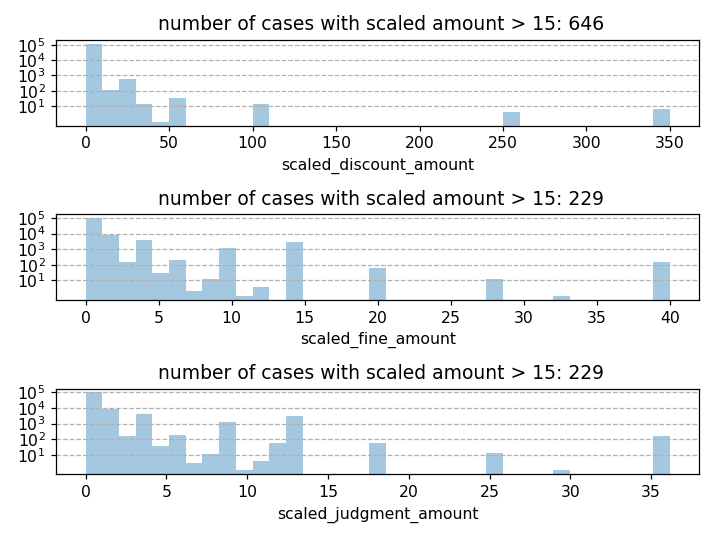

In [9]:
plt.subplots(3,1)
for i,j in enumerate(['scaled_discount_amount', 'scaled_fine_amount', 'scaled_judgment_amount']):
    outliers_fines = X_train[j].where( X_train[j]>15).dropna().index
    
    plt.subplot(3,1,i+1)
    sns.distplot(X_train[j],kde=False,norm_hist=False,bins=35)
    plt.gca().set_yscale("log")
    plt.grid(linestyle='--',axis="y")
    plt.gca().set_yticks([1e1,1e2,1e3,1e4,1e5])
    plt.tight_layout()
    plt.title(" number of cases with scaled amount > 15: {}".format( len(outliers_fines) ) )

All the data points with a lat-lot distance > 2 from the origin are dropped for the training:

In [10]:
origin_distance = lambda  x: np.sqrt( x["scaled_lat"]*x["scaled_lat"] + x["scaled_lon"]*x["scaled_lon"] )
outliers_geog = X_train.where( X_train.apply(origin_distance,axis=1) > 2 )
outliers_geog = outliers_geog.dropna().index
print("compliance values for geographical outliers: {}".format(y_train.loc[outliers_geog].unique()))

compliance values for geographical outliers: [0.0]
Categories (1, float64): [0.0]


<IPython.core.display.Javascript object>


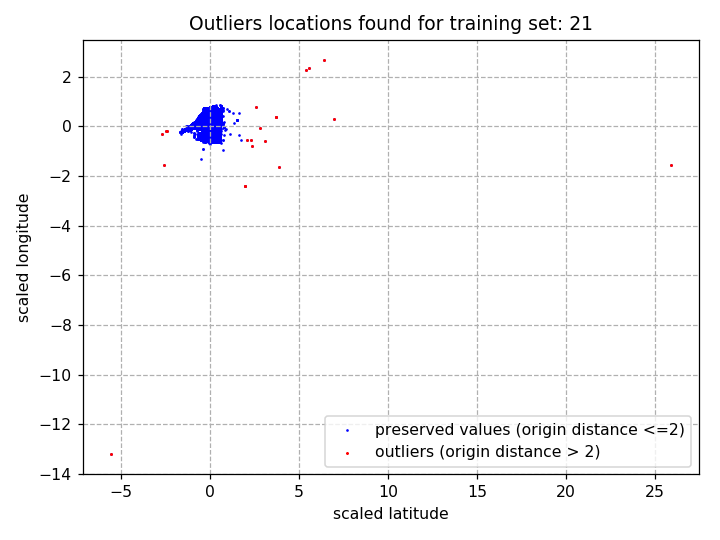

In [11]:
plt.figure()
plt.scatter(X_train.scaled_lat,X_train.scaled_lon,marker='o',c="b",s=0.5,label="preserved values (origin distance <=2)")
plt.scatter(X_train.loc[outliers_geog].scaled_lat,X_train.loc[outliers_geog].scaled_lon,marker='*',c="r",s=1,label="outliers (origin distance > 2)")
plt.xlabel("scaled latitude")
plt.ylabel("scaled longitude")
plt.title("Outliers locations found for training set: {}".format(X_train.loc[outliers_geog].count().unique()[0]   ))
plt.grid(linestyle='--')
plt.legend(loc="lower right")
plt.tight_layout()

### final features:

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117399 entries, 107479 to 116671
Data columns (total 54 columns):
address_0                       117399 non-null int64
address_1                       117399 non-null int64
address_2                       117399 non-null int64
address_3                       117399 non-null int64
address_4                       117399 non-null int64
address_5                       117399 non-null int64
address_6                       117399 non-null int64
address_7                       117399 non-null int64
address_8                       117399 non-null int64
address_9                       117399 non-null int64
address_10                      117399 non-null int64
address_11                      117399 non-null int64
address_12                      117399 non-null int64
address_13                      117399 non-null int64
address_14                      117399 non-null int64
address_15                      117399 non-null int64
address_16          

# Model development

In [14]:
logit = LogisticRegression()
grid_values = {'C': [1e-2,1e-1, 1, 10, 50], 'penalty':['l1','l2']}

### Logit using full X_train set

In [15]:
grid_clf = train_and_cross_validate(logit,X_train,y_train,grid_values,scoring="roc_auc")
print("best score: {}".format(grid_clf.best_score_))
confusion_mat(y_true=y_test,y_pred=grid_clf.predict(X_test))

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


--- 239.25544118881226 seconds ---
best score: 0.7843731290717381


,Predicted 0,Predicted 1
True 0,19230,14
True 1,1300,174


<IPython.core.display.Javascript object>


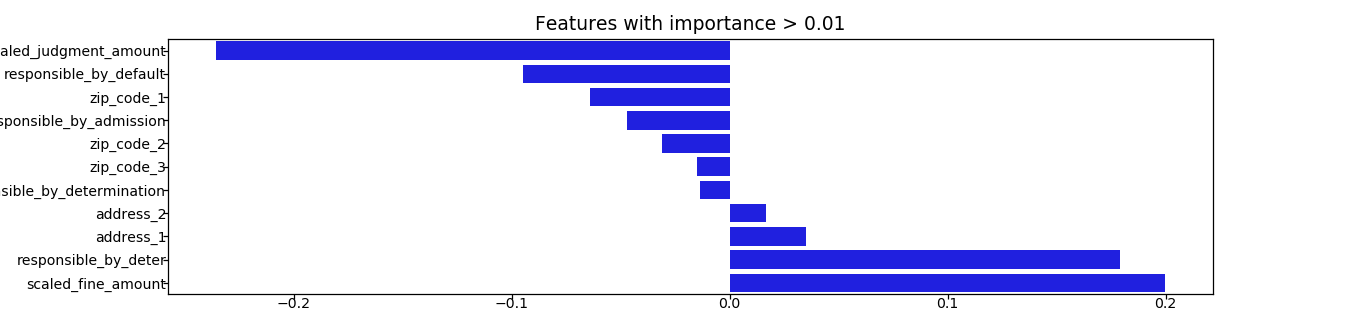

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


In [16]:
_,_ =get_feature_importance(grid_clf,X_train,threshold=1e-2,saveplot="")

### Logit without outliers and F1-score

In [17]:
X_train_no_outl = X_train.drop(index=outliers_geog.append(outliers_fines))
grid_clf = train_and_cross_validate(model=logit,X_train=X_train_no_outl,y_train=y_train,parameters=grid_values,scoring="f1")
print("best score: {}".format(grid_clf.best_score_))
confusion_mat(y_true=y_test,y_pred=grid_clf.predict(X_test))

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


--- 242.2488420009613 seconds ---
best score: 0.2193434377568593


,Predicted 0,Predicted 1
True 0,19230,14
True 1,1300,174


<IPython.core.display.Javascript object>


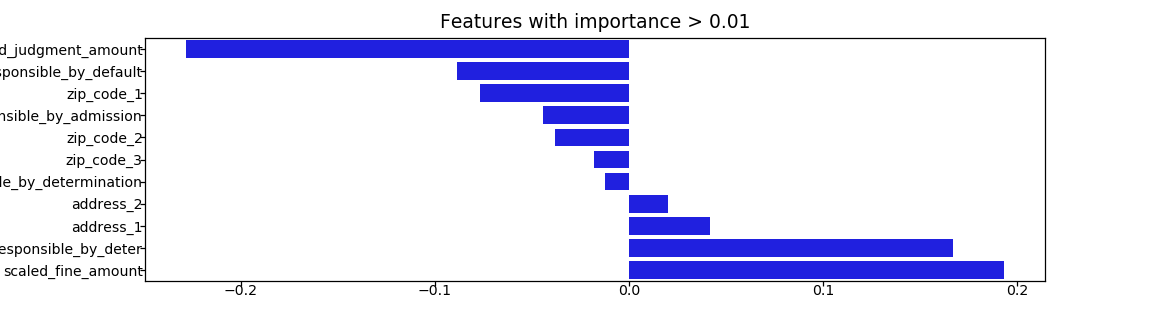

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


In [18]:
_,_ =get_feature_importance(grid_clf,X_train_no_outl,threshold=1e-2,saveplot="")

### Logit without address and zip_code features

In [20]:
important_features = ['scaled_judgment_amount', 'responsible_by_default',
       'responsible_by_admission', 'responsible_by_determination','scaled_discount_amount', 'responsible_by_deter',
       'scaled_fine_amount']
grid_clf= train_and_cross_validate(model=logit,X_train=X_train[important_features],y_train=y_train,parameters=grid_values,scoring="roc_auc")
print("best score: {}".format(grid_clf.best_score_))
confusion_mat(y_true=y_test,y_pred=grid_clf.predict(X_test[important_features]))

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


--- 44.74229311943054 seconds ---
best score: 0.7869114327963158


,Predicted 0,Predicted 1
True 0,19233,11
True 1,1316,158


<IPython.core.display.Javascript object>


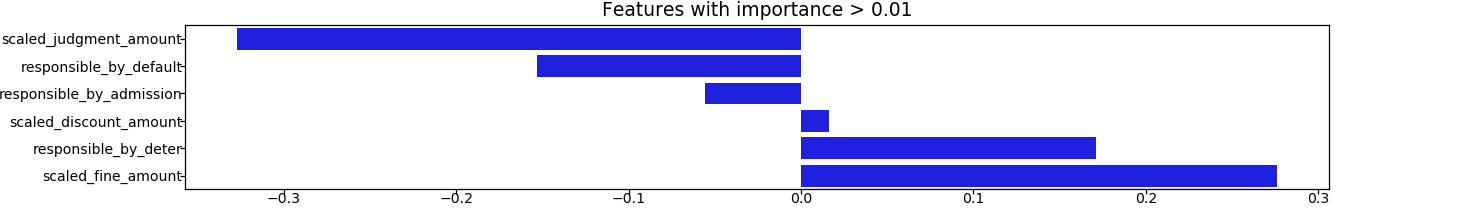

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


In [22]:
importances,features = get_feature_importance(grid_clf,X_train[important_features])